In [1]:
import sys

COMMON_DIR = "/mnt/d/github/computer_vision/books/generative_deep_learning/pytorch/common"
if COMMON_DIR not in sys.path:
    sys.path.append(COMMON_DIR)

from common.datasets import get_train_loader, get_test_loader
from common.utils import set_seed, plot_images, create_images
from common.trainer import fit, evaluate, predict

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision.transforms as T

In [3]:
### Data Loading
from common.datasets import CIFAR10

root_dir = "/mnt/d/datasets/cifar10"
train_loader = get_train_loader(dataset=CIFAR10(root_dir, "train"), batch_size=64)
test_loader = get_test_loader(dataset=CIFAR10(root_dir, "test"), batch_size=32)

batch = next(iter(train_loader))
images, labels = batch["image"], batch["label"]
print(f"\ntrain dataset: {len(train_loader.dataset)}, dataloader: {len(train_loader)}")
print(f"train images: {images.shape}, {images.dtype}, {images.min()}, {images.max()}")
print(f"train labels: {labels.shape}, {labels.dtype}, {labels.min()}, {labels.max()}")

batch = next(iter(test_loader))
images, labels = batch["image"], batch["label"]
print(f"\ntest dataset: {len(test_loader.dataset)}, dataloader: {len(test_loader)}")
print(f"test  images: {images.shape}, {images.dtype}, {images.min()}, {images.max()}")
print(f"test  labels: {labels.shape}, {labels.dtype}, {labels.min()}, {labels.max()}")


train dataset: 50000, dataloader: 781
train images: torch.Size([64, 3, 32, 32]), torch.float32, 0.0, 1.0
train labels: torch.Size([64]), torch.int64, 0, 9

test dataset: 10000, dataloader: 313
test  images: torch.Size([32, 3, 32, 32]), torch.float32, 0.0, 1.0
test  labels: torch.Size([32]), torch.int64, 0, 9


In [ ]:
class MLP(nn.Module):
    def __init__(self, in_channels=3, num_classes=10):
        super().__init__()
        self.in_channels = in_channels
        self.linear1 = nn.Sequential(nn.Linear(32 * 32 * in_channels, 512), nn.ReLU())
        self.linear2 = nn.Sequential(nn.Linear(512, 256), nn.ReLU())
        self.fc = nn.Linear(256, num_classes)

    def forward(self, x):
        x = x.view(-1, 32 * 32 * self.in_channels)
        x = self.linear1(x)
        x = self.linear2(x)
        x = self.fc(x)
        return x

In [ ]:
from torchmetrics import Accuracy

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MLP(in_channels=3, num_classes=10).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
acc_metric = Accuracy(task="multiclass", num_classes=10).to(device)

num_epochs = 10
model.train()
for epoch in range(1, num_epochs + 1):
    results = {"loss": 0.0, "acc": 0.0}
    total = 0
    for batch in train_loader:
        images = batch["image"].to(device)
        labels = batch["label"].to(device)
        batch_size = images.size(0)
        total += batch_size

        optimizer.zero_grad()
        preds = model(images)
        loss = loss_fn(preds, labels)
        loss.backward()
        optimizer.step()

        results["loss"] += loss.item() * batch_size
        with torch.no_grad():
            results["acc"] += acc_metric(preds, labels) * batch_size

    print(f"[{epoch:2d}/{num_epochs}] "
          f"loss={results['loss']/total:.3f}, acc={results['acc']/total:.3f}")

[ 1/10] loss=1.847, acc=0.331
[ 2/10] loss=1.664, acc=0.404
[ 3/10] loss=1.577, acc=0.435
[ 4/10] loss=1.518, acc=0.457
[ 5/10] loss=1.472, acc=0.471
[ 6/10] loss=1.442, acc=0.484
[ 7/10] loss=1.415, acc=0.495
[ 8/10] loss=1.381, acc=0.504
[ 9/10] loss=1.359, acc=0.514
[10/10] loss=1.340, acc=0.522


In [ ]:
from models.classifier import Classifier

encoder = MLP(in_channels=3, num_classes=10)
model = Classifier(encoder, num_classes=10)
history = fit(model, train_loader, num_epochs=10, valid_loader=test_loader)

[  1/10] loss:1.845, acc:0.333 | (val) loss:1.692, acc:0.396                       
[  2/10] loss:1.665, acc:0.400 | (val) loss:1.599, acc:0.425                       
[  3/10] loss:1.575, acc:0.438 | (val) loss:1.533, acc:0.457                       
[  4/10] loss:1.514, acc:0.460 | (val) loss:1.509, acc:0.460                       
[  5/10] loss:1.478, acc:0.473 | (val) loss:1.474, acc:0.473                       
[  6/10] loss:1.439, acc:0.485 | (val) loss:1.479, acc:0.473                       
[  7/10] loss:1.408, acc:0.496 | (val) loss:1.442, acc:0.477                       
[  8/10] loss:1.384, acc:0.505 | (val) loss:1.423, acc:0.495                       
[  9/10] loss:1.351, acc:0.518 | (val) loss:1.436, acc:0.490                       
[ 10/10] loss:1.335, acc:0.523 | (val) loss:1.438, acc:0.490                       


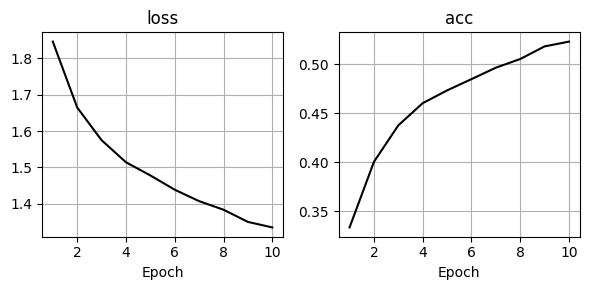

In [ ]:
from common.utils import plot_history

plot_history(history["train"])